In [3]:
from src.utils.data_utils import load_dataframe_from_csv
from src.data.dataloader import load_initial_dataset
from clean_cmu import clean_movies_cmu
#from config import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

# What makes a movie win an award?

With the subquestions stated in our README, this `results.ipynb` shows how we are able to have a quality dataset that will serve for our data analysis.

First, we fetch our Oscars award winning dataset of actors, and our dataset that is enriched.


In [4]:
movie = load_dataframe_from_csv('movie_cmu.csv')
character = load_dataframe_from_csv('character.csv')
plot_summaries = load_dataframe_from_csv('plot_summaries.csv')
tvtropes = load_dataframe_from_csv('tvtropes.csv')
name_clusters = load_dataframe_from_csv('name_clusters.csv')
oscar_winning_films = load_dataframe_from_csv('oscar_winning_films_ids.csv')
oscar_winning_actors = load_dataframe_from_csv('oscar_winning_actors.csv')
oscar_winning_actresses = load_dataframe_from_csv('oscar_winning_actresses.csv')
oscar_supporting_actors = load_dataframe_from_csv('oscar_winning_supporting_actors.csv')
oscar_supporting_actresses = load_dataframe_from_csv('oscar_winning_supporting_actresses.csv')
extended_films = load_dataframe_from_csv('film_2015_2024.csv')
academy_award_winning_films = load_dataframe_from_csv('acedemy_award_winning_films')
winning_actors_info = load_dataframe_from_csv('winning_actors_information.csv')

In [124]:
import ast
movie = clean_movies_cmu(movie)
movie.rename(columns={'Wikipedia movie ID': 'page_id', 'Movie name': 'film', 'Movie genres' : 'genres', 'Movie languages' : 'languages', 'Movie box office revenue' : 'box_office', 'Movie runtime' : 'runtime', 'Movie countries' : 'countries'}, inplace=True)
movie['genres'] = movie['genres'].apply(lambda s : s.split(','))


extended_films['runtime'] = pd.to_numeric(extended_films['runtime'],  errors='coerce')
extended_films['genres'] = extended_films['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else '[]')

In [166]:
genres_extended = set(value.lower().strip() for row in extended_films['genres'] for value in row)
genres_cmu = set(value.lower().strip() for row in movie['genres'] for value in row)

genres = genres_cmu.union(genres_extended)

<b> ASK GPT AI TO CLASSIFY <b>

In [183]:
from openai import OpenAI

client = OpenAI(api_key=OPEN_AI_KEY)	

 
assistant = client.beta.assistants.create(
    name="Category film classifier",
    instructions=(
        "I will provide a list of film genres. Your task is to classify each genre "
        "into a broader category. If the genre is already broad, retain it. "
        "Provide the classification in JSON format, mapping each genre to its category. "
        "Example: {'thriller': 'Drama', 'dark comedy': 'Comedy'}."
    ),
    model="gpt-4",
    tools=[
        {
            "type": "function",
            "function": {
                "name": "get_genre",
                "description": "Get a broader genre for each genre in the given genre list",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "genres": {
                            "type": "array",
                            "items": {"type": "string"},
                            "description": "A list of genre names (e.g., 'Drama', 'Comedy')."
                        }
                    },
                    "required": ["genres"]
                }
            }
        }
    ]
)

thread = client.beta.threads.create()
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content=f"What are the broader genre for each genres in this list dont hesitate to create new ones or to classify them into existing categories you created? {genres}",
)

In [184]:
from typing_extensions import override
from openai import AssistantEventHandler

# Global list to store tool outputs
global_tool_outputs = []

class EventHandler(AssistantEventHandler):
    @override
    def on_event(self, event):
        # Check for 'requires_action' events
        if event.event == 'thread.run.requires_action':
            run_id = event.data.id  # Get the run ID from the event data
            self.handle_requires_action(event.data, run_id)

    def handle_requires_action(self, data, run_id):
        tool_outputs = []  # Local list to hold tool outputs for this event
        
        # Iterate over tool calls
        for tool in data.required_action.submit_tool_outputs.tool_calls:
            if tool.function.name == "get_genre":
                tool_output = {"tool_call_id": tool.id, "output": "57"}  # Example output
                tool_outputs.append(tool_output)
                global_tool_outputs.append(tool_output)  # Store in the global list
        
        # Submit all tool outputs at the same time
        self.submit_tool_outputs(tool_outputs, run_id)

    def submit_tool_outputs(self, tool_outputs, run_id):
        # Use the submit_tool_outputs_stream helper
        with client.beta.threads.runs.submit_tool_outputs_stream(
            thread_id=self.current_run.thread_id,
            run_id=self.current_run.id,
            tool_outputs=tool_outputs,
            event_handler=EventHandler(),
        ) as stream:
            for text in stream.text_deltas:
                print(text, end="", flush=True)
            print()

# Start the stream and use the event handler
with client.beta.threads.runs.stream(
    thread_id=thread.id,
    assistant_id=assistant.id,
    event_handler=EventHandler()
) as stream:
    stream.until_done()

# Print the stored results after the stream is complete
print("Collected Tool Outputs:", global_tool_outputs)


I'm sorry for misunderstanding. The return value should be a genre-category correlation in JSON format. Let's correct this.

{
  '': 'Other',
  'detective': 'Crime',
  'northern': 'Regional',
  'historical': 'Drama',
  'non-narrative': 'Experimental',
  'tragicomedy': 'Comedy',
  'extreme sports': 'Sports',
  'teen': 'Drama',
  'sexploitation': 'Erotic',
  'women in prison films': 'Drama',
  'short film': 'Short',
  'roadshow/carny': 'Adventure',
  'stoner': 'Comedy',
  'female buddy film': 'Comedy',
  'revenge': 'Action',
  'noir fiction': 'Noir',
  'revisionist fairy tale': 'Fantasy',
  'beach party film': 'Comedy',
  'medical fiction': 'Drama',
  'space western': 'Sci-Fi',
  'werewolf fiction': 'Horror',
  'singing cowboy': 'Western',
  'parkour in popular culture': 'Sports',
  'interpersonal relationships': 'Drama',
  'mystery play': 'Mystery',
  'biopic [feature]': 'Biography',
  'comedy thriller': 'Comedy',
  'dystopia': 'Sci-Fi',
  'crime': 'Crime',
  'feature film': 'General',


Here, we can see that we fetched all Oscars winning actors and actresses, and that gives us a relevant sample for our further analysis


In [6]:
print("More information about the oscar winning actors")

print(winning_actors_info.value_counts())

More information about the oscar winning actors
page_id   wikidata_id  actor                sexLabel  nativeLanguageLabel  countryOfCitizenshipLabel  ethnicGroupLabel   
11181     Q40912       Frank Sinatra        male      American English     United States of America   Italian Americans      1
13717     Q1033016     Halle Berry          female    English              United States of America   African Americans      1
20647767  Q103343      Jennifer Connelly    female    American English     United States of America   Norwegian Americans    1
12684530  Q189490      Jennifer Lawrence    female    English              United States of America   British Americans      1
8694199   Q229254      Octavia Spencer      female    English              United States of America   African Americans      1
3741746   Q147077      Emma Stone           female    English              United States of America   British Americans      1
1086198   Q150482      J. K. Simmons        male      English       

We plot the age of the oscar winning actors and actresses, we could 

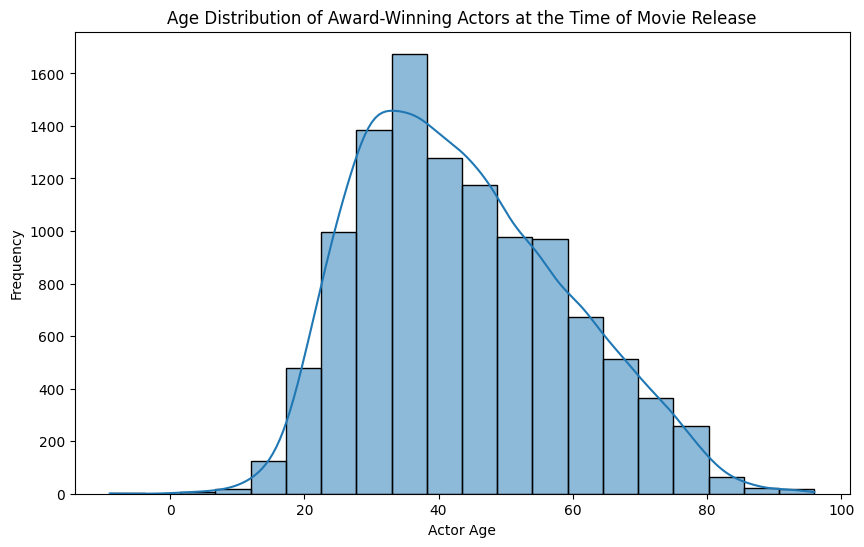

In [7]:
# Filtering the characters DataFrame to include only award-winning actors
filtered_characters = character[character['Actor name'].isin(winning_actors_info['actor'])].copy()

# Ensure 'filtered_characters' is a proper copy to avoid SettingWithCopyWarning
filtered_characters.dropna(subset=['Actor age at movie release'], inplace=True)

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_characters['Actor age at movie release'], bins=20, kde=True)
plt.title('Age Distribution of Award-Winning Actors at the Time of Movie Release')
plt.xlabel('Actor Age')
plt.ylabel('Frequency')
plt.show()

By plotting this age distribution, we can see that most winning actors are middle-age with 30-40 years old.

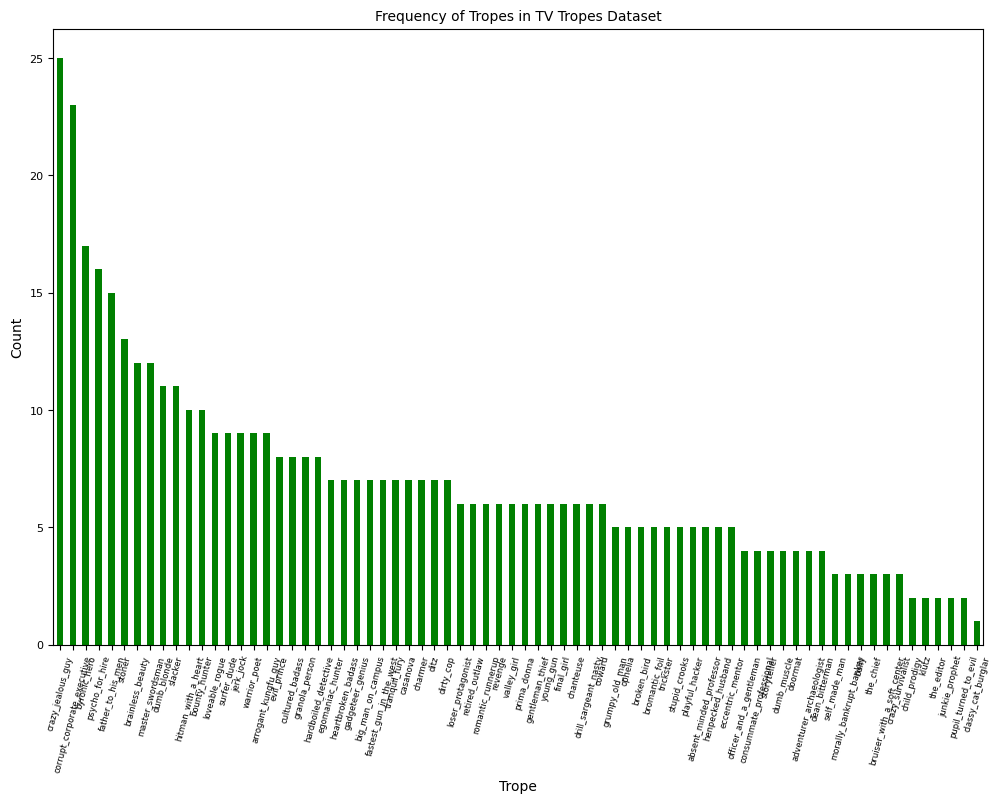

In [8]:
trope_counts = tvtropes['Trope'].value_counts()
plt.figure(figsize=(12, 8))
trope_counts.plot(kind='bar', color='green')
plt.xlabel('Trope', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Frequency of Tropes in TV Tropes Dataset', fontsize=10)
plt.xticks(rotation=75, fontsize=6)
plt.yticks(fontsize=8)
plt.show()

Here is the bar plot of most common genres in award-winning films.

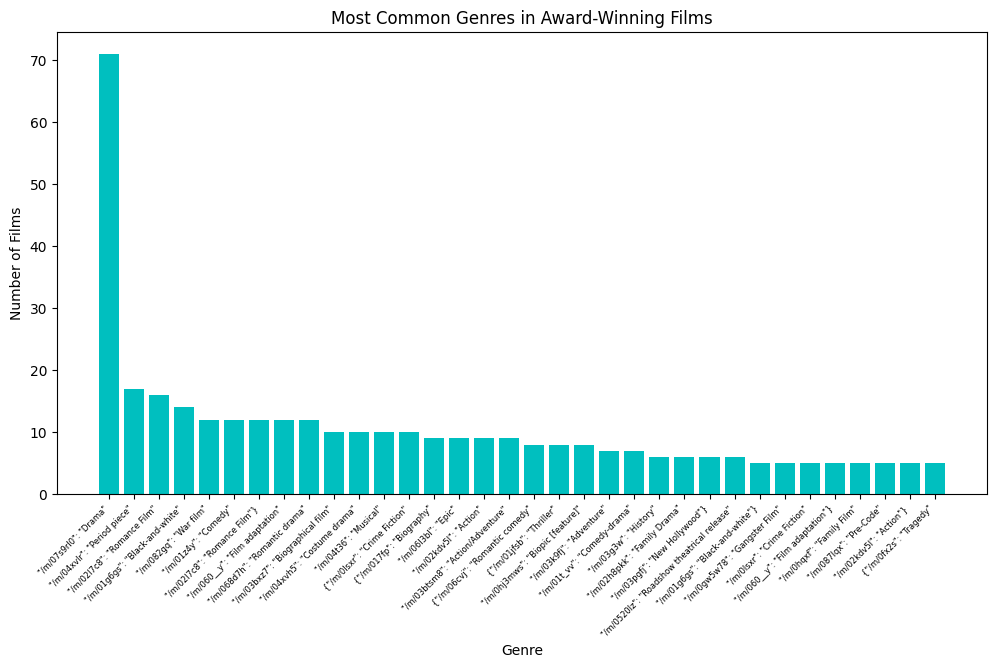

In [9]:
from collections import Counter 

oscar_films_ids = oscar_winning_films['Page ID']
oscar_films = movie[movie['Wikipedia movie ID'].isin(oscar_winning_films['Page ID'])]

# Flatten the list of genres and count occurrences
all_genres = [genre for sublist in oscar_films['Movie genres'].str.split(', ') for genre in sublist]
genre_counts = Counter(all_genres)

# Convert the counts to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

# Filter genres with at least 20 movies
genre_counts_df = genre_counts_df[genre_counts_df['Count'] >= 5]

# Plot the genre counts as a bar chart
plt.figure(figsize=(12, 6))
genre_counts_df.sort_values(by='Count', ascending=False, inplace=True)
plt.bar(genre_counts_df['Genre'], genre_counts_df['Count'], color='c')

plt.xticks(rotation=45, ha='right', fontsize=6)
plt.title('Most Common Genres in Award-Winning Films')
plt.ylabel('Number of Films')
plt.xlabel('Genre')
plt.show()

We can see that we have a lot more drama movies than other genre of movies, we have then to balance the data.

Here is the distribution of review score, primal for our comparison with reviews.

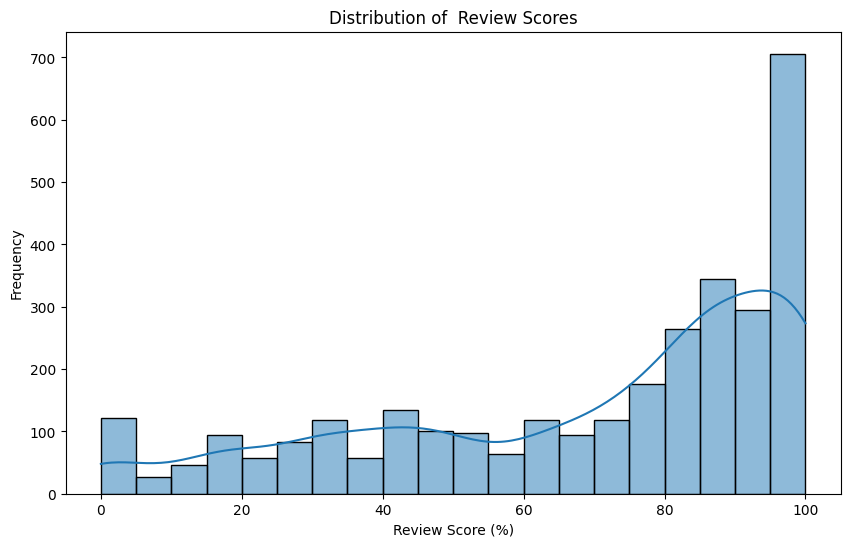

In [10]:
# Extract the first review score from the reviewScores column

# Drop rows with missing review scores
review_scores = extended_films['reviewScores'].dropna().apply(lambda x: [score for score in eval(x) if score != ['']]).dropna()
review_scores = review_scores.apply(lambda x: x[0] if len(x) > 0 else None).dropna()

# Convert the review scores to numeric values, ignoring errors
review_scores = pd.to_numeric(review_scores.str.replace('%', ''), errors='coerce').dropna()

# Plot the distribution of review scores
plt.figure(figsize=(10, 6))
sns.histplot(review_scores, bins=20, kde=True)
plt.title('Distribution of  Review Scores')
plt.xlabel('Review Score (%)')
plt.ylabel('Frequency')
plt.show()

The review scores are clearly going towards the 100%, but this can be because we are using the dataset of award-winning films.

Here is the sentiment compound distribution of plot summaries.

In [11]:
# Plot the distribution of sentiment compound
plt.figure(figsize=(10, 6))
sns.histplot(plot_summaries['sentiment_compound'], bins=20, kde=True)
plt.title('Distribution of Sentiment Compound in Plot Summaries')
plt.xlabel('Sentiment Compound')
plt.ylabel('Frequency')
plt.show()

KeyError: 'sentiment_compound'

<Figure size 1000x600 with 0 Axes>

Here, using the CMU dataset, we apply some sentiment analysis from the NLTK corpus. Hence we can see here that most of plot summaries are more negative (-1) than positive (+1).

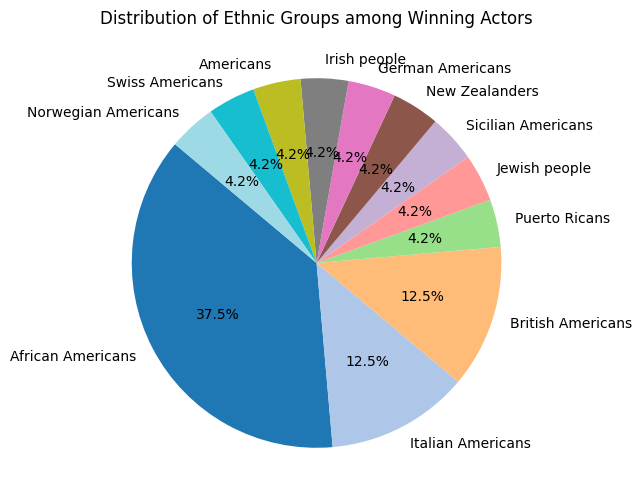

In [12]:
# Drop rows with missing ethnicGroupLabel
ethnic_group_counts = winning_actors_info['ethnicGroupLabel'].dropna().value_counts()

# Plotting the pie chart
plt.figure(figsize=(10, 6))
ethnic_group_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap='tab20')
plt.title('Distribution of Ethnic Groups among Winning Actors')
plt.ylabel('')  # Hide the y-label
plt.show()

By using the winning actors dataset, we can see the ethnicity distribution of actors. Hence, we can see that ther is a strong proportion of African Americans.  

In [13]:
oscar_winning_films

,Page ID
0,61046
1,61182
2,4592959
3,2410609
4,44752
...,...
91,56746570
92,59935792
93,66255918
94,58342225


In [14]:
extended_films

,page_id,wikidata_id,film,release_date,box_office,runtime,languages,countries,genres,reviewScores,awardsReceived,awardsNominated,capitalCost,release date
0,48716179,Q21646407,First Rank Raju,2015-01-01T00:00:00Z,NaN,NaN,Kannada,India,['drama'],[''],[''],[''],NaN,2015
1,46967307,Q20311376,A 2nd Hand Lover,2015-01-01T00:00:00Z,NaN,NaN,Kannada,India,['musical'],[''],[''],[''],NaN,2015
2,48837152,Q24521064,"3 1/2 Minutes, 10 Bullets",2015-01-24T00:00:00Z,NaN,98,English,United States of America,"['documentary', 'crime']","['100%', '7.7/10']",['Sundance Special Jury Prize Documentary'],[''],NaN,2015
3,44838624,Q18701869,3 Bahadur,2015-01-01T00:00:00Z,NaN,94,Urdu,Pakistan,"['adventure', ""children's""]",[''],[''],[''],NaN,2015
4,46896101,Q20770561,3 Generations,2015-09-18T00:00:00Z,NaN,87,"English, Spanish",United States of America,"['drama', 'LGBT-related', 'comedy']","['31%', '5/10']",[''],[''],NaN,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27002,77719767,Q129815195,Yudhra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27003,76212902,Q124694939,Yumi's Cells: The Movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27004,74732328,Q122194265,Yuva,2023-12-22T00:00:00Z,NaN,NaN,NaN,India,[''],[''],[''],[''],NaN,2023
27005,77736917,Q130014181,Z-Mom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
movie

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}",Norway,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",United Kingdom,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}",Germany,"{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","Ireland, United Kingdom","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}",Japan,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


Let's do a clustering